# Titanic Data를 가지고 탑승자의 생존여부를 추측해보기 - Kaggle

- Kaggle의 가장 기본적인 데이터인 타이타닉 탑승자의 데이터 프로젝트를 작업해보자!
- 우리의 목적: 타이타닉 탑승자의 여러가지 데이터가 주어지고 이를 바탕으로 탑승자의 생존여부를 추측하는 것이다.

# 0. 기본 설정

In [1]:
import numpy as np 
import os  
import matplotlib ##그림용
import matplotlib.pyplot as plt ##그림용
import sklearn ##사이킷런
import pandas as pd

np.random.seed(42) ##랜덤시드 

matplotlib.rc('font', family='NanumBarunGothic') ##matplotlib 한글을 위해
plt.rcParams['axes.unicode_minus'] = False ##한글을 위해

# 1. 데이터 불러오기

- 캐글에서 타이타닉 데이터를 다운받고, 원하는 폴더에 넣기

In [2]:
TITANIC_PATH = 'datasets/titanic'

def load_titanic_data_train(titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "train.csv")
    return pd.read_csv(csv_path)

def load_titanic_data_submission(titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "test.csv")
    return pd.read_csv(csv_path)

In [3]:
titanic = load_titanic_data_train()
titanic_submission = load_titanic_data_submission()

- 데이터를 불러왔으니 간략하게 살펴보자

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 타깃 값은 어떤건지 알아보기
    - 주어진 데이터에의 특성의 개수가 많을 수도 있으니 자동화해놓자.

In [5]:
for column in titanic.columns:
    if column not in titanic_submission.columns:
        print(column, " is not in test data ")
    else:
        print(column)

PassengerId
Survived  is not in test data 
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


- Survived가 우리가 예측할 타깃 값이다.

# 2. 자료 둘러보기

## 1. 자료 둘러보기

In [6]:
titanic.info()  ##1. 누락값 체크 2. 저장된 자료형 체크

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


주어진 데이터를 보자.
1. 우리의 데이터 개수는 891개, 특성의 개수는 12개이다. 데이터의 수가 적어 과적합이 일어날 가능성이 높다.
2. PassengerId와 Name의 경우 각 객체의 identity 값이므로 알고리즘에 들어가기 전에 삭제하자.
3. Survived와 Pclass의 경우 명목형 변수이지만 int값을 가지고 있다.
4. 주어진 데이터의 명목형 변수: Survived, Pclass, Sex, Ticket, Cabin, Embarked
5. 결측치가 있는 특성: Age, Cabin, Embarked

명목형 변수가 어떻게 구성되어 있는지 살펴보자

1. Sex

male      577
female    314
Name: Sex, dtype: int64

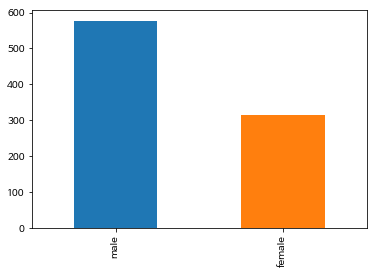

In [7]:
display(titanic["Sex"].value_counts())
titanic["Sex"].value_counts().plot(kind='bar')
plt.show()

남자의 수가 여자에 비해 상대적으로 많다. 약 2배정도 차이가 난다.

2. Ticket

In [8]:
display(titanic["Ticket"].value_counts().head())
display(pd.Series(titanic["Ticket"].value_counts()==1).value_counts())

CA. 2343    7
347082      7
1601        7
CA 2144     6
347088      6
Name: Ticket, dtype: int64

True     547
False    134
Name: Ticket, dtype: int64

대략적으로 전체의 1/4 정도가 결측치이다. 그리고 명목형 변수임에도 불구하고, 한 클래스에 1 객체만 들어있는 클래스의 개수가 547개, 전체 데이터의 1/2가 넘는 양이다. 이 특성을 삭제하는 것이 좋을 듯하다.

3. Cabin

In [9]:
display(titanic["Cabin"].value_counts().head())
display(pd.Series(titanic["Cabin"].value_counts()==1).value_counts())

C23 C25 C27    4
G6             4
B96 B98        4
F33            3
C22 C26        3
Name: Cabin, dtype: int64

True     101
False     46
Name: Cabin, dtype: int64

전체 데이터의 4/5정도가 결측치이고 이 중 한 클래스에 1 객체만 있는 클래스의 개수가 많다. 이 특성을 삭제하는 것이 나을 듯하다.

4. Embarked

In [10]:
titanic["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

결측치는 2개이다. 대부분 사람들은 Embarked 값이 S다.

,Fare
Embarked,
C,59.954144
Q,13.276030
S,27.079812


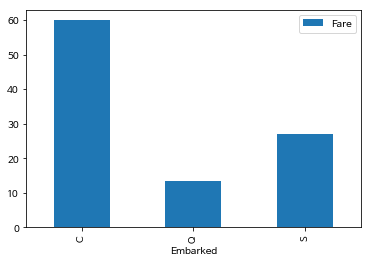

In [11]:
display(titanic[["Embarked", "Fare"]].groupby(["Embarked"]).mean())
display(titanic[["Embarked", "Fare"]].groupby(["Embarked"]).mean().plot(kind="bar"))
plt.show()

탑승한 위치와 낸 티켓값은 상관이 있을 가능성이 높다. 나중에 결측치를 채울 때, Fare값을 이용하면 될 것 같다.

In [12]:
titanic[titanic["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


- 숫자형 자료의 통계치 체크

In [13]:
titanic_num = titanic.drop(['PassengerId', 'Pclass', 'Survived'], axis=1)
titanic_num.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


    - 그림을 통한 인사이트 얻기 시도

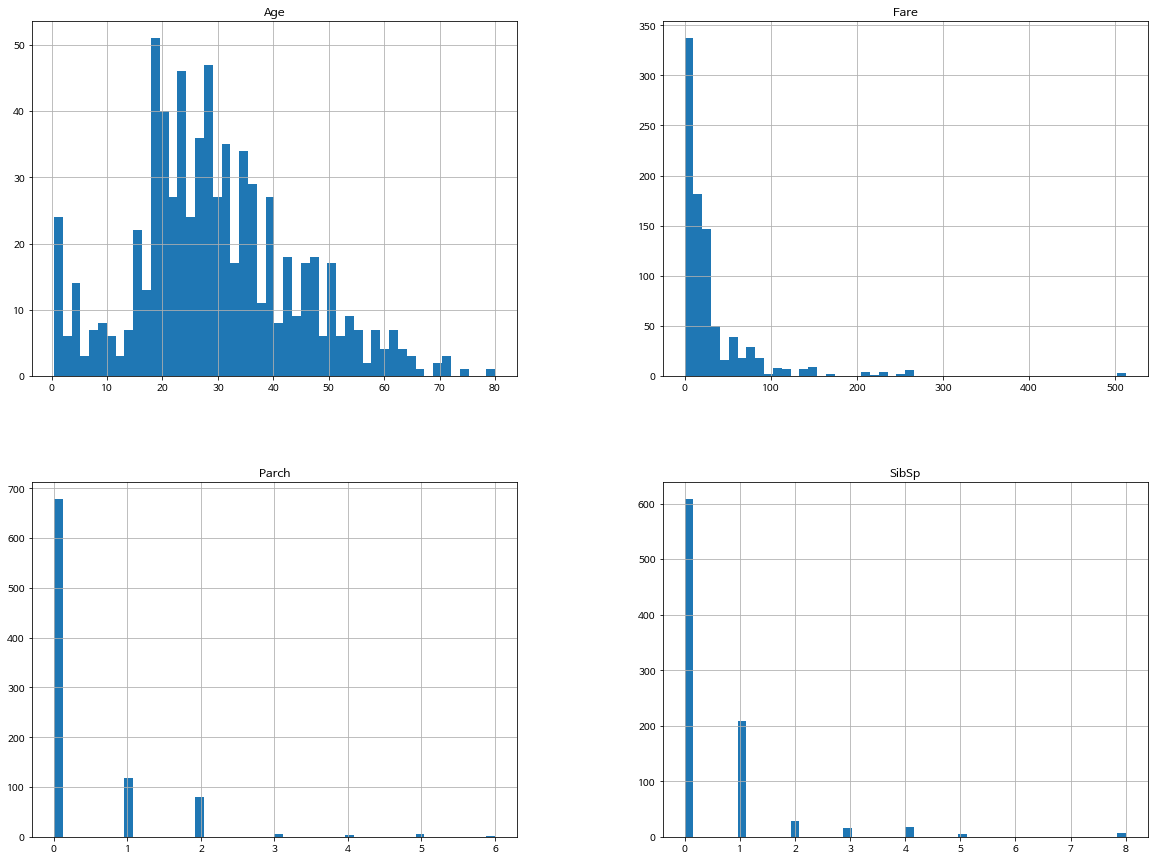

In [14]:
titanic_num.hist(bins=50, figsize=(20,15))
plt.show()

4개의 수치형 데이터들은 모두 우측 꼬리가 긴 형태이다. 나중에 꼬리를 자르거나 정규화를 해야겠다.

# 2. train set과 test set으로 나누기

이 데이터의 경우에는 test set이 따로 있으므로 나누지 않아도 됨

# 3. 데이터 이해를 위한 탐색

## 1. 특성 조합

원본 데이터를 손상시키지 않기 위해 카피본을 준비하자

In [15]:
titanic_tmp = titanic.copy()

In [16]:
titanic_tmp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


형제의 수나 자식의 수 혹은 부모의 수로 가족의 수를 나누는 것보다 가족의 수를 생각하는 게 유의미할 것 같다. 가족이 함께 탔는지 혹은 함께 타지 않았는지 명목형 변수화해도 될 것 같다.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sum_SibSp_Parch
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


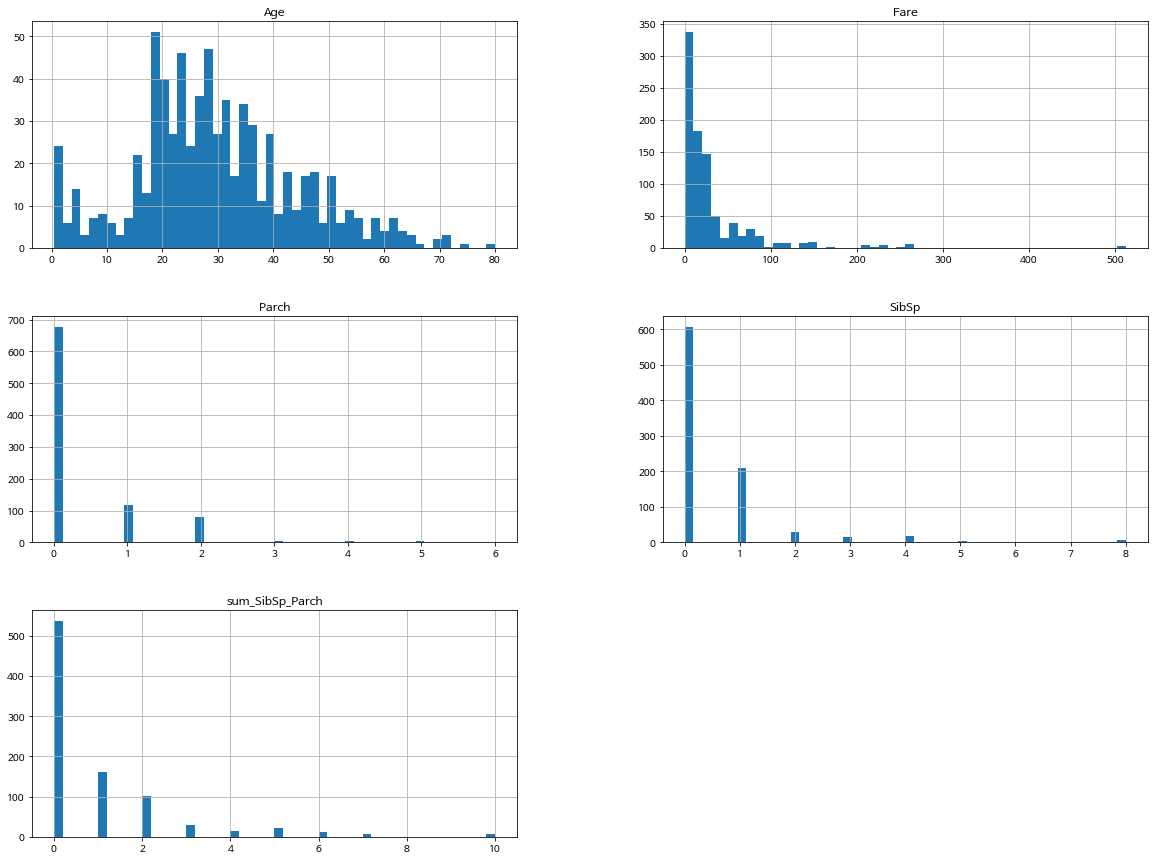

In [17]:
titanic_tmp["sum_SibSp_Parch"] = titanic_tmp["SibSp"] + titanic_tmp["Parch"]
titanic_num = titanic_tmp.drop(['PassengerId', 'Pclass', 'Survived'], axis=1)
display(titanic_tmp.head())
titanic_num.hist(bins=50, figsize=(20,15))
plt.show()

# 3. 데이터 전처리

## 1. 데이터 정제, 결측치 처리하기

In [18]:
titanic_labels = titanic["Survived"].copy()

In [19]:
titanic.drop(["Survived"], axis=1, inplace=True)
titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


결측치를 해결할 3가지 선택지가 있음
- 해당 구역 제거
- 전체 특성 삭제
- 어떤 값으로 채움  
 
이 중  
Age는 옵션 3  
Cabin은 옵션 1  
Embarked는 옵션 3    
을 쓰도록 하자.

### - Cabin 처리

In [21]:
titanic.drop("Cabin", axis=1, inplace=True)

### - Embarked 처리

In [22]:
titanic[titanic["Embarked"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [23]:
titanic["Embarked"].fillna('C', inplace=True) ##Fare에 따른 값 추가

### - Age 처리

이름을 가지고 추론하자. 나이에 따라 이름에 Mr, Mrs, Miss, Master 식으로 달리 들어가게 된다.

In [24]:
Mr = r'Mr[.]'
Mrs = r'Mrs[.]'
Miss = r'Miss[.]'
Master = r'Master[.]'
All = r'Mr[.]|Mrs[.]|Miss[.]|Master[.]'

Name_cat = [Mr, Mrs, Miss, Master]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
titanic_num_including_Name = titanic.drop(["Sex","Ticket",'Embarked',"Pclass"], axis=1)
titanic_num_including_Name.head()

,PassengerId,Name,Age,SibSp,Parch,Fare
0,1,"Braund, Mr. Owen Harris",22.0,1,0,7.2500
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833
2,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000
4,5,"Allen, Mr. William Henry",35.0,0,0,8.0500


In [25]:
null = pd.DataFrame()
for i in range(len(Name_cat)):
    a = titanic_num_including_Name[
                titanic_num_including_Name["Name"].str.contains(Name_cat[i])]
    imputer.fit(a.drop("Name", axis=1))
    b = imputer.transform(a.drop("Name", axis=1))
    b = pd.DataFrame(b)
    null = pd.concat([null, b])

a = titanic_num_including_Name[
                titanic_num_including_Name["Name"].str.contains(All)==False]
imputer.fit(a.drop("Name", axis=1))
b = imputer.transform(a.drop("Name", axis=1))
b = pd.DataFrame(b)
null = pd.concat([null, b])
    
titanic_num_prepare = null

titanic_num_prepare.columns = titanic_num_including_Name.drop(
                                                "Name", axis=1).columns

titanic_num_prepare = titanic_num_prepare.sort_values(by=["PassengerId"])
titanic_num_prepare.head()

,PassengerId,Age,SibSp,Parch,Fare
0,1.0,22.0,1.0,0.0,7.2500
0,2.0,38.0,1.0,0.0,71.2833
0,3.0,26.0,0.0,0.0,7.9250
1,4.0,35.0,1.0,0.0,53.1000
1,5.0,35.0,0.0,0.0,8.0500


In [26]:
null = pd.DataFrame()
for i in range(len(Name_cat)):
    a = titanic_num_including_Name[
                titanic_num_including_Name["Name"].str.contains(Name_cat[i])]
    imputer.fit(a.drop("Name", axis=1))
    b = imputer.transform(a.drop("Name", axis=1))
    b = pd.DataFrame(b)
    null = pd.concat([null, b])

a = titanic_num_including_Name[
                titanic_num_including_Name["Name"].str.contains(All)==False]
imputer.fit(a.drop("Name", axis=1))
b = imputer.transform(a.drop("Name", axis=1))
b = pd.DataFrame(b)
null = pd.concat([null, b])
    
titanic_num_prepare = null

titanic_num_prepare.columns = titanic_num_including_Name.drop(
                                                "Name", axis=1).columns

titanic_num_prepare = titanic_num_prepare.sort_values(by=["PassengerId"])
titanic_num_prepare.head()

,PassengerId,Age,SibSp,Parch,Fare
0,1.0,22.0,1.0,0.0,7.2500
0,2.0,38.0,1.0,0.0,71.2833
0,3.0,26.0,0.0,0.0,7.9250
1,4.0,35.0,1.0,0.0,53.1000
1,5.0,35.0,0.0,0.0,8.0500


## 2. 텍스트와 범주형 특성 다루기

In [27]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [28]:
titanic_cat = titanic[["Sex", "Embarked", "Pclass"]]
titanic_cat.head(10)

,Sex,Embarked,Pclass
0,male,S,3
1,female,C,1
2,female,S,3
3,female,S,1
4,male,S,3
5,male,Q,3
6,male,S,1
7,male,S,3
8,female,S,3
9,female,C,2


In [29]:
titanic_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
Sex         891 non-null object
Embarked    891 non-null object
Pclass      891 non-null int64
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


In [30]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
titanic_cat_encoded = cat_encoder.fit_transform(titanic_cat)
titanic_cat_encoded.toarray()[:10]

array([[0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 1., 0.]])

In [31]:
cat_encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object),
 array([1, 2, 3], dtype=object)]

## 3. 나만의 변환기

1. 나이 결측값 이름에 따라 채우기
2. PassengerId, Name, Ticket, Cabin,버리기
3. SibSp, Parch 합한 값 추가하고 SibSp, Parch 버리기
4. Embarked 채우기

### 1. 이름 기준 나이 결측값 채우기

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class NumberTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer_strategy='median'):
        self.imputer = SimpleImputer(strategy=imputer_strategy)
    def fit(self, X, y=None):
        return (self)
    def transform(self, X, y=None):
        Mr = r'Mr[.]'
        Mrs = r'Mrs[.]'
        Miss = r'Miss[.]'
        Master = r'Master[.]'
        All = r'Mr[.]|Mrs[.]|Miss[.]|Master[.]'
        Name_cat = [Mr, Mrs, Miss, Master]
        
        num_tr = pd.DataFrame()
        for i in range(len(Name_cat)):
            a = X[X["Name"].str.contains(Name_cat[i])]
            imputer.fit(a.drop("Name", axis=1))
            b = imputer.transform(a.drop("Name", axis=1))
            b = pd.DataFrame(b)
            num_tr = pd.concat([num_tr, b])
        
        
        a = X[X["Name"].str.contains(All)==False]
        imputer.fit(a.drop("Name", axis=1))
        b = imputer.transform(a.drop("Name", axis=1))
        b = pd.DataFrame(b)
        num_tr = pd.concat([num_tr, b])
        
        
        num_tr.columns = X.drop("Name", axis=1).columns
        num_tr = num_tr.sort_values(by=["PassengerId"])
        num_tr = num_tr.drop("PassengerId", axis=1)
        
        return num_tr.reset_index(drop=True)

### 2. Ticket, Cabin, Fare버리기
1.에서 Name과 PassengerId를 버렸음  
embarked 결측치를 채우기위해 Fare를 나중에 추가해야 하기 때문에 다시 삭제해줘야함 밑에서 코드로 보기

In [33]:
class Remover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(['Ticket', 'Cabin', "Fare"], axis=1)

### 3. SibSp, Parch 합한 값 추가하고 SibSp, Parch 버리기

In [34]:
class Sum_and_Remove(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["sum_SibSp_Parch"] = X["SibSp"] + X["Parch"]
        return X.drop(["SibSp", "Parch"], axis=1)

### 4. Embarked 채우기

In [35]:
class Fill_Embarked(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.reset_index()
        X_tmp = X[X["Embarked"].isnull()]
        num = len(X_tmp)
        
        for i in range(num):
            tmp_index = X_tmp["index"].iloc[i]
            if X.loc[tmp_index, "Fare"] > (60 + 27) / 2:
                X.loc[tmp_index, "Embarked"] = "C"
            elif X.loc[tmp_index, "Fare"] <= (60 + 27)/2 or X.loc[tmp_index, "Fare"] >(27 + 18) / 2:
                X.loc[tmp_index, "Embarked"] = "S"
            else:
                X.loc[tmp_index, "Embarked"] = "Q"
        
        return X.drop(["index"], axis=1)

## 4. 변환 파이프라인

In [36]:
titanic = load_titanic_data_train()
titanic.drop(["Survived"], axis=1, inplace=True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', NumberTransformer()),
    ('Sum_and_Remove', Sum_and_Remove()),
    ('std_scaler', StandardScaler()),
    ])

In [38]:
titanic_num_tr = num_pipeline.fit_transform(
                    titanic_num_including_Name)
titanic_num_tr.shape

(891, 3)

#### 수치형 자료와 명목형자료 데이터 뽑는 처리 추가하기

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names] ##2장에서는 .value가 있지만 우리의 NumberTransformer는 데이터 프레임을 다룸

In [40]:
num_attribs = list(titanic_num_including_Name)
cat_attribs = list(titanic_cat) +["Cabin", "Fare", "Ticket"] #Fare는 잠시 추가 >_-

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', NumberTransformer()),
    ('Sum_and_Remove', Sum_and_Remove()),
    ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('Fill_Embarked', Fill_Embarked()),
    ('Remover', Remover()),
    ('cat_pipeline', OneHotEncoder(sparse=False)),    
    ])

In [41]:
titanic_cat_tr = cat_pipeline.fit_transform(titanic)

In [42]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
    ])

In [43]:
titanic_prepared = full_pipeline.fit_transform(titanic)

In [44]:
titanic_prepared.shape

(891, 11)

파이프 라인 완성!

# 4. 모델 선택

1. 여기서는 auc로 주어진 알고리즘을 평가한다.
2. pure한 예측을 얻기 위해 cross_val_predict을 쓴다.

1. 랜덤 포래스트

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=3)
forest_clf.fit(titanic_prepared, titanic_labels)

from sklearn.model_selection import cross_val_predict

titanic_train_pred = cross_val_predict(forest_clf, titanic_prepared, titanic_labels, cv=10)

from sklearn.metrics import confusion_matrix

confusion_matrix(titanic_labels, titanic_train_pred)

from sklearn.metrics import roc_auc_score

roc_auc_score(titanic_train_pred, titanic_labels)


0.8111577021761855

2. SGD

In [46]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(titanic_prepared, titanic_labels)

from sklearn.model_selection import cross_val_predict

titanic_train_pred = cross_val_predict(sgd_clf, titanic_prepared, titanic_labels, cv=10)

from sklearn.metrics import confusion_matrix

confusion_matrix(titanic_labels, titanic_train_pred)

from sklearn.metrics import roc_auc_score

roc_auc_score(titanic_train_pred, titanic_labels)

0.7024669134425231

3. SVM

In [47]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(C=1, loss="hinge")
svm_clf.fit(titanic_prepared, titanic_labels)

from sklearn.model_selection import cross_val_predict

titanic_train_pred = cross_val_predict(svm_clf, titanic_prepared, titanic_labels, cv=10)

from sklearn.metrics import confusion_matrix

confusion_matrix(titanic_labels, titanic_train_pred)

from sklearn.metrics import roc_auc_score

roc_auc_score(titanic_train_pred, titanic_labels)

0.7765650354899601

4. decision tree

In [48]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(titanic_prepared, titanic_labels)

from sklearn.model_selection import cross_val_predict

titanic_train_pred = cross_val_predict(tree_clf, titanic_prepared, titanic_labels, cv=10)

from sklearn.metrics import confusion_matrix

confusion_matrix(titanic_labels, titanic_train_pred)

from sklearn.metrics import roc_auc_score

roc_auc_score(titanic_train_pred, titanic_labels)

0.8157726081921316

# 5. 테스트 세트로 시스템 평가

In [49]:
def submission(clf, clf_name):
    titanic_submission_prepared = full_pipeline.transform(titanic_submission)
    final_predictions = clf.predict(titanic_submission_prepared)
    final_predictions = pd.DataFrame(final_predictions)
    submission = pd.concat([titanic_submission["PassengerId"],final_predictions], axis = 1)
    submission.columns = ["PassengerId","Survived"]
    submission.to_csv("submission\\final_predictions_%s.csv" %clf_name, header=True, index=False)

In [50]:
submission(forest_clf, 'forest_clf')
## in test 0.77990

In [51]:
submission(sgd_clf, 'sgd_clf')
## in test 0.69377

In [52]:
submission(svm_clf, 'svm_clf')
## in test 0.76555

In [53]:
submission(tree_clf, 'tree_clf')
## in test 0.79425

결과.   
80% 정도 추측하는게 최대값이다. 특이한점이 있다면 tree가 forest보다 예측을 더 잘했다.

프로젝트를 하면서 궁금했던점.  
1. 타깃 값이 "survived" 1 혹은 0인데(수치형 자료인데) 분류기를 쓰면 명목화를 자동으로 해주는지?
    - 명목화를 자동으로 해주기는 한다. 하지만 지금 데이터는 결과가 0 혹은 1이기 때문에 별 문제가 없었지만, 만약에 제출할 때, 'Survived', 'Not Survived' 식으로 이름을 말해야한다면, 뒤쪽에 코딩을 더 해서 저런 식으로 예측할 수 있게 조작해야함
    - ex) A, B, C  중 하나를 예측해야 할 때, 결과는 0,1,2 중 하나로 나오니, 0 - A, 1 - B, 2 - C를 이어주는 코딩을 더 해야함
    

2. 정확도(accuracy), auc, pr곡선의 넓이 중, 어느것을 언제 사용하는지?
     - auc, pr곡선은 모델 전체에 대한 평가
         - 일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 pr 곡선을 사용하고 그렇지 않으면 auc를 사용한다. auc가 일반적으로 사용된다.
         - auc, pr곡선은 이진 분류일 때 사용한다.
         - 다중분류일 때는 오차 행렬을 분석하는 정도만 배웠다.
    - accuracy는 auc나 pr곡선에서 한 점을 나타낸다.
    - 따라서 auc나 pr곡선을 이용해 어떤 모델을 쓸 지 정하고 그래프를 분석하면서 threshold를 정하면 된다.
        - 각 분류기에 따라 threshold를 정하는 방법이 다르다(확률 혹은 점수).


3. 수치형 데이터(Pclass)를 원핫인코더에 넣으면 명목화해주는지
    - 맞음. 하지만 column하나가 남는다. 이런 부분을 해결하고 싶다면, get_dummies를 이용할 수 있다.

4. 꼬리가 긴 수치형 데이터를 꼬리를 자르는게 좋을까?
    - 꼬리는 앵간하면 안자르는게 좋음
    - 로그변환 혹은 Box-Cox 변환을 해주면 좋음

5. 가족의 수의 경우, 가족이 없는 경우 혹은 있는 경우로 나누는 게 유의미할까?
    - 시도해봐야 알 수 있다.

6. 타깃 값이 명목형 변수일 때 상관 관계 분석이 유의미한지? 이에 대응하는 분류기에 분석이 있는지?
    - 카이제곱 검증을 통해, 종속변수와 설명변수의 독립성 혹은 상관성을 분석할 수 있다(명목 설명 변수 vs 명목 종속 변수).
    - 스피어맨 상관 계수 분석을 해볼 수 있다(수치 설명 변수(명목화 해야함) vs 명목 종속 변수).